<a href="https://colab.research.google.com/github/JeremiahKamama/Spacy-Analysis/blob/main/analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
import spacy
import string
import re

from spacy.lang.en import English
from spacy.tokens import Doc
from spacy.lang.en.stop_words import STOP_WORDS
from spacy.tokenizer import Tokenizer

from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score,confusion_matrix,f1_score
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer

from wordcloud import WordCloud



In [2]:

nlp = spacy.load("en_core_web_sm", disable=['ner', 'parser', 'tagger'])




In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
imdb = pd.read_csv('/content/drive/MyDrive/data/IMDB.csv')

imdb.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


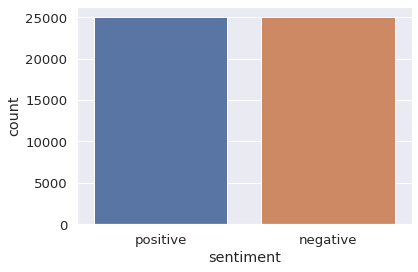

In [9]:
sns.set(style = 'darkgrid', font_scale = 1.2)
sns.countplot(imdb.sentiment)

In [10]:
imdb.describe()

,review,sentiment
count,50000,50000
unique,49582,2
top,Loved today's show!!! It was a variety and not...,positive
freq,5,25000


In [7]:
imdb.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB


In [11]:
imdb.sentiment.replace("positive", 1 , inplace= True)
imdb.sentiment.replace("negative", 0, inplace= True)
imdb.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,1
1,A wonderful little production. <br /><br />The...,1
2,I thought this was a wonderful way to spend ti...,1
3,Basically there's a family where a little boy ...,0
4,"Petter Mattei's ""Love in the Time of Money"" is...",1


In [12]:
miss_val = imdb.isnull().sum()

miss_val[0:10]

review       0
sentiment    0
dtype: int64

In [13]:
stopwords = list(STOP_WORDS)
print(stopwords)

['next', 'someone', 'a', 'too', '‘m', 'may', 'also', 'namely', 'mine', 'therefore', 'your', 'three', 'whether', 'twenty', 'nor', 'on', 'became', 'whom', 'still', 'via', 'can', 'have', 'she', 'does', 'i', 'would', 'do', 'could', 'if', 'along', 'n‘t', 'hundred', 'fifty', 'nothing', 'amongst', 'beside', 'wherever', 'per', 'sometime', 'whence', 'fifteen', 'none', 'nevertheless', "'ve", 'beyond', 'hereby', 'no', 'used', 'her', 'formerly', 'me', 'us', 'seeming', 'just', 'many', 'why', 'every', 'give', 'without', 'under', 'move', 'across', 'it', 'sixty', 'they', 'throughout', 'been', 'doing', 'before', 'due', 'elsewhere', 'therein', 'seemed', 'really', 'neither', 'through', 'eleven', 'each', 'thereby', 'yourself', 'behind', 'has', 'five', 'since', 'afterwards', 'thereafter', 'anyone', 'nowhere', 'latter', 'hereupon', 'keep', 'former', 'up', 'so', 'noone', 'into', 'yours', "'m", 'everything', 'to', 'full', 'over', 'mostly', 'here', 'anything', 'as', '’d', 'nobody', 'further', 'whereby', 'empty

In [14]:
punct = string.punctuation
print(punct)

!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~


In [15]:
 def my_tokenizer(sentence):
  doc = nlp(sentence)
  tokens =[]

  for token in doc:
    if token.lemma_ != '-PRON-':
      temp = token.lemma_.lower().strip()
    else:
      temp = token.lower_
    tokens.append(temp)

  clean_tokens = []

  for token in tokens:
    if token not in punct:
      clean_tokens.append(token)
      
  return clean_tokens

In [23]:
imdb['review'][2]

'I thought this was a wonderful way to spend time on a too hot summer weekend, sitting in the air conditioned theater and watching a light-hearted comedy. The plot is simplistic, but the dialogue is witty and the characters are likable (even the well bread suspected serial killer). While some may be disappointed when they realize this is not Match Point 2: Risk Addiction, I thought it was proof that Woody Allen is still fully in control of the style many of us have grown to love.<br /><br />This was the most I\'d laughed at one of Woody\'s comedies in years (dare I say a decade?). While I\'ve never been impressed with Scarlet Johanson, in this she managed to tone down her "sexy" image and jumped right into a average, but spirited young woman.<br /><br />This may not be the crown jewel of his career, but it was wittier than "Devil Wears Prada" and more interesting than "Superman" a great comedy to go see with friends.'

In [24]:
text = imdb['review'][2]
print(text)

I thought this was a wonderful way to spend time on a too hot summer weekend, sitting in the air conditioned theater and watching a light-hearted comedy. The plot is simplistic, but the dialogue is witty and the characters are likable (even the well bread suspected serial killer). While some may be disappointed when they realize this is not Match Point 2: Risk Addiction, I thought it was proof that Woody Allen is still fully in control of the style many of us have grown to love.<br /><br />This was the most I'd laughed at one of Woody's comedies in years (dare I say a decade?). While I've never been impressed with Scarlet Johanson, in this she managed to tone down her "sexy" image and jumped right into a average, but spirited young woman.<br /><br />This may not be the crown jewel of his career, but it was wittier than "Devil Wears Prada" and more interesting than "Superman" a great comedy to go see with friends.


In [25]:
doc = nlp(text)
print(doc)

I thought this was a wonderful way to spend time on a too hot summer weekend, sitting in the air conditioned theater and watching a light-hearted comedy. The plot is simplistic, but the dialogue is witty and the characters are likable (even the well bread suspected serial killer). While some may be disappointed when they realize this is not Match Point 2: Risk Addiction, I thought it was proof that Woody Allen is still fully in control of the style many of us have grown to love.<br /><br />This was the most I'd laughed at one of Woody's comedies in years (dare I say a decade?). While I've never been impressed with Scarlet Johanson, in this she managed to tone down her "sexy" image and jumped right into a average, but spirited young woman.<br /><br />This may not be the crown jewel of his career, but it was wittier than "Devil Wears Prada" and more interesting than "Superman" a great comedy to go see with friends.


In [26]:
my_tokenizer(text)

['i',
 'think',
 'this',
 'be',
 'a',
 'wonderful',
 'way',
 'to',
 'spend',
 'time',
 'on',
 'a',
 'too',
 'hot',
 'summer',
 'weekend',
 'sit',
 'in',
 'the',
 'air',
 'condition',
 'theater',
 'and',
 'watch',
 'a',
 'light',
 'hearted',
 'comedy',
 'the',
 'plot',
 'be',
 'simplistic',
 'but',
 'the',
 'dialogue',
 'be',
 'witty',
 'and',
 'the',
 'character',
 'be',
 'likable',
 'even',
 'the',
 'good',
 'bread',
 'suspect',
 'serial',
 'killer',
 'while',
 'some',
 'may',
 'be',
 'disappoint',
 'when',
 'they',
 'realize',
 'this',
 'be',
 'not',
 'match',
 'point',
 '2',
 'risk',
 'addiction',
 'i',
 'think',
 'it',
 'be',
 'proof',
 'that',
 'woody',
 'allen',
 'be',
 'still',
 'fully',
 'in',
 'control',
 'of',
 'the',
 'style',
 'many',
 'of',
 'us',
 'have',
 'grow',
 'to',
 'love.<br',
 '/><br',
 '/>this',
 'be',
 'the',
 'much',
 'i',
 'would',
 'laugh',
 'at',
 'one',
 'of',
 'woody',
 'have',
 'comedy',
 'in',
 'year',
 'dare',
 'i',
 'say',
 'a',
 'decade',
 'while',
 '

In [27]:
imdb['review'] = imdb['review'].apply(lambda x: re.sub('[,\.!?:()"]', '', x))
imdb['review'] = imdb['review'].apply(lambda x: re.sub('[^a-zA-Z"]', ' ', x))
imdb['review'] = imdb['review'].apply(lambda x: x.lower())
imdb['review'] = imdb['review'].apply(lambda x: x.strip())


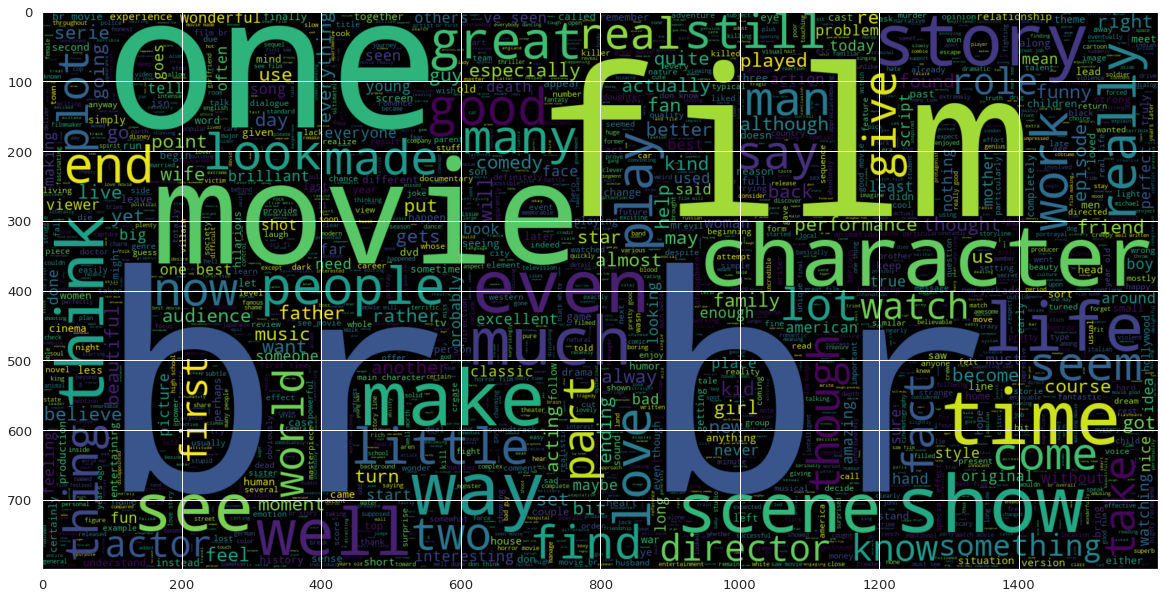

In [28]:
plt.figure(figsize = (20,20))
cloud = WordCloud(max_words= 2000, width= 1600,height= 800).generate("".join(imdb[imdb.sentiment == 1].review))
plt.imshow(cloud, interpolation='bilinear')

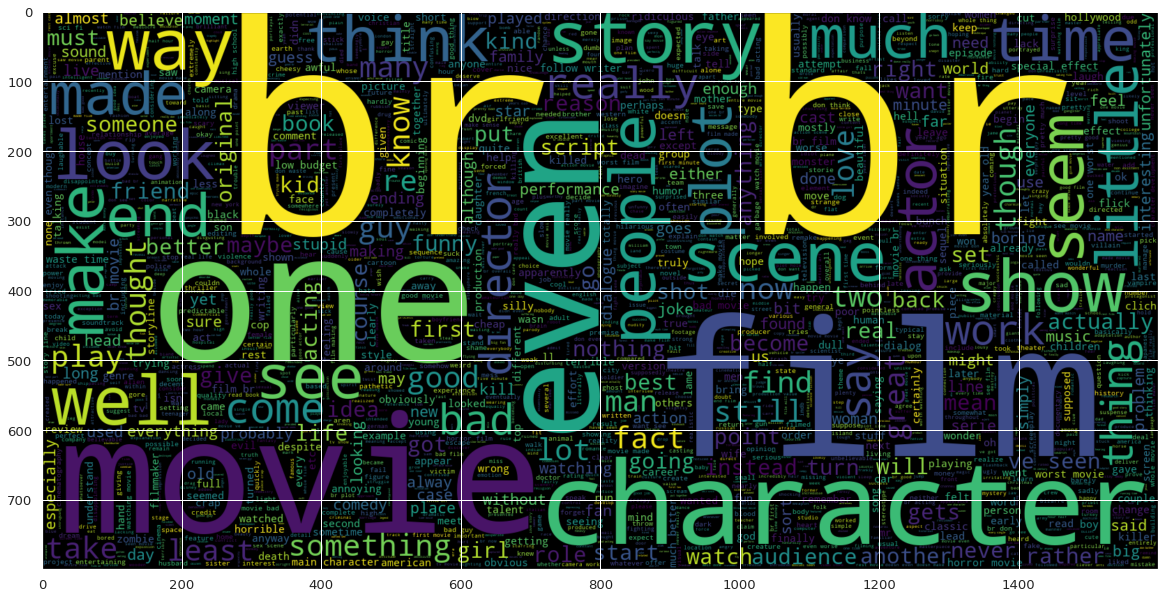

In [29]:
plt.figure(figsize = (20,20))
cloud = WordCloud(max_words= 2000, width= 1600,height= 800).generate("".join(imdb[imdb.sentiment == 0].review))
plt.imshow(cloud, interpolation='bilinear')

In [30]:
X = imdb['review']
y = imdb['sentiment']

X_train,X_test, y_train,y_test = train_test_split(X,y, test_size=0.2, random_state=42)



In [36]:
X_train.shape, X_test.shape, y_train.shape

((40000,), (10000,), (40000,))

In [41]:
tfvectorizer = TfidfVectorizer(tokenizer = my_tokenizer)

text_cf = Pipeline([('tfidf', tfvectorizer),('classifier',LinearSVC())])

In [42]:
text_cf.fit(X_train,y_train)

predictions = text_cf.predict(X_test)

accuracy = accuracy_score(y_test,y_pred)

f1 = f1_score(y_test,y_pred)

print(f"F1 Score : {f1} and Accuracy Score {accuracy}")

F1 Score : 0.8334530528476142 and Accuracy Score 0.8377


In [45]:
from sklearn.metrics import classification_report

print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.82      0.87      0.84      4961
           1       0.86      0.81      0.83      5039

    accuracy                           0.84     10000
   macro avg       0.84      0.84      0.84     10000
weighted avg       0.84      0.84      0.84     10000



In [46]:
cm = confusion_matrix(y_test,y_pred)
print(cm)

[[4316  645]
 [ 978 4061]]


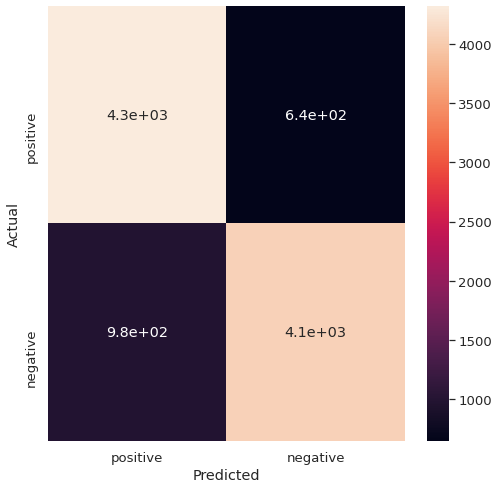

In [47]:
plt.figure(figsize = (8,8))
sns.heatmap(cm, annot=True, xticklabels = ['positive','negative'] , yticklabels = ['positive','negative']) 
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [49]:
review = imdb['review']

In [50]:
from tensorflow.python.keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense, Embedding,LSTM
from tensorflow.python.keras.preprocessing.text import Tokenizer
from keras.optimizers import Adam
from keras.layers import Dropout
from tensorflow.python.keras.preprocessing.sequence import pad_sequences
from tensorflow.python.keras.models import load_model

In [51]:
tokenizer = Tokenizer(num_words= 15000)
tokenizer.fit_on_texts(review)

In [52]:
train_tokens = tokenizer.texts_to_sequences(X_train)
test_tokens = tokenizer.texts_to_sequences(X_test)

In [53]:
num_tokens = [len(tokens) for tokens in train_tokens + test_tokens]
num_tokens = np.array(num_tokens)

In [54]:
max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
max_tokens = int(max_tokens)
max_tokens

567

In [55]:
train_pad = pad_sequences(train_tokens, maxlen=max_tokens)
test_pad = pad_sequences(test_tokens, maxlen=max_tokens)


In [56]:
idx = tokenizer.word_index
inverse_map = dict(zip(idx.values(), idx.keys()))

def return_to_sentence(tokens):
    words = [inverse_map[token] for token in tokens if token!=0]
    text = ' '.join(words)
    return text

In [57]:
print(return_to_sentence(train_pad[8]))

the people who are bad this film are those who don t understand film to begin with these are the people who love movie blockbusters and to any movie that doesn t star leonardo dicaprio wilder is a neat little film that may seem quirky and maybe even stupid at first but what it lacks in plot it more than makes up for in substance br br one thing in particular about the movie that impressed me was it s use of music which plays a large part those students of film music will notice how important music is in the movie both in and wilder s life and in the background wilder s theme s theme and wallace s theme are all heard in the opening sequence and it is funny how some of the lyrics play out for instance in the scene where the men are singing duke of earl is with wilder when the men sing something like she is my girl and then she goes over to wallace to give him something when the men sing the she will be my girl cleverly showing the tension between the two brothers there are all sorts of l

In [58]:
print(train_pad[8])

[    0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0   

In [59]:
from keras import Sequential 
from keras.layers import Embedding,LSTM,Dense, Dropout

embedding_size=100

model = Sequential()

model.add(Embedding(input_dim=15000,output_dim=embedding_size,input_length=max_tokens,name="embedding_layer"))

model.add(LSTM(units=16,return_sequences= True))
model.add(Dropout(0.1))

model.add(LSTM(units=8,return_sequences=True))
model.add(Dropout(0.1))

model.add(LSTM(units=4))
model.add(Dropout(0.1))

model.add(Dense(1, activation='sigmoid'))

optimizer = Adam(learning_rate=1e-3)

model.compile(loss='binary_crossentropy',optimizer=optimizer,metrics=['accuracy'])


In [60]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_layer (Embedding)  (None, 567, 100)          1500000   
_________________________________________________________________
lstm (LSTM)                  (None, 567, 16)           7488      
_________________________________________________________________
dropout (Dropout)            (None, 567, 16)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 567, 8)            800       
_________________________________________________________________
dropout_1 (Dropout)          (None, 567, 8)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 4)                 208       
_________________________________________________________________
dropout_2 (Dropout)          (None, 4)                 0

In [61]:
history = model.fit(train_pad, y_train, validation_split=0.3, epochs=5, batch_size=1000, shuffle=True, verbose = 1)

Epoch 1/5
28/28 [==============================] - 38s 551ms/step - loss: 0.6878 - accuracy: 0.5866 - val_loss: 0.6328 - val_accuracy: 0.6975
Epoch 2/5
28/28 [==============================] - 14s 493ms/step - loss: 0.5680 - accuracy: 0.7681 - val_loss: 0.4552 - val_accuracy: 0.8235
Epoch 3/5
28/28 [==============================] - 13s 465ms/step - loss: 0.3989 - accuracy: 0.8709 - val_loss: 0.4108 - val_accuracy: 0.8331
Epoch 4/5
28/28 [==============================] - 14s 489ms/step - loss: 0.3233 - accuracy: 0.9012 - val_loss: 0.3672 - val_accuracy: 0.8605
Epoch 5/5
28/28 [==============================] - 13s 463ms/step - loss: 0.2569 - accuracy: 0.9307 - val_loss: 0.3601 - val_accuracy: 0.8630


In [62]:
result = model.evaluate(test_pad, y_test)


313/313 [==============================] - 36s 110ms/step - loss: 0.3434 - accuracy: 0.8712


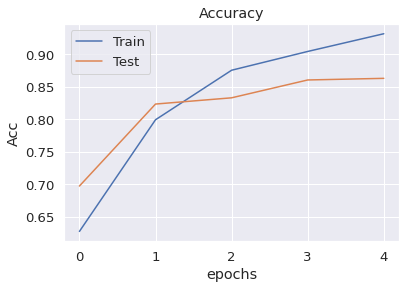

In [63]:
plt.figure()
plt.plot(history.history["accuracy"], label = "Train")
plt.plot(history.history["val_accuracy"], label = "Test")
plt.title("Accuracy")
plt.ylabel("Acc")
plt.xlabel("epochs")
plt.legend()
plt.show()


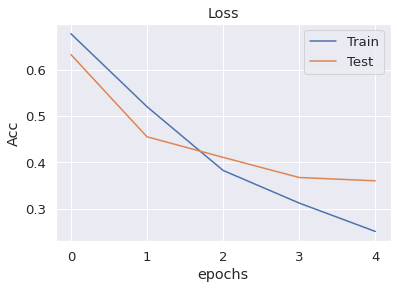

In [64]:
plt.figure()
plt.plot(history.history["loss"], label = "Train")
plt.plot(history.history["val_loss"], label = "Test")
plt.title("Loss")
plt.ylabel("Acc")
plt.xlabel("epochs")
plt.legend()
plt.show()
